In [131]:
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.special import comb
import math
from scipy.optimize import fsolve
import pandas as pd
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.collections import LineCollection
import datetime;

# 1. Noiseless Authors

## 1.1 Review burden versus review quality $\beta$ and the number of solicited reviews $m$

We fix the conference's optimal threshold at the point that all good papers just about to submit and all bad
papers just about to not submit. 
The corresponding review burden at this acceptance threshold is plotted for different $\beta$ and $m$.

In [67]:
"""
Some tool functions
"""

# Binomial probability: m draws, l success, b success probability
def review_prob_f(m,l,b):
    return math.comb(m,l)*np.power(b,l)*np.power(1-b,m-l)

# Binomial probability: m draws, l or more success, b success probability
def review_prob_F(m,l,b):
    sum_p = 0
    for i in range(l,m+1):
        sum_p += review_prob_f(m,i,b)
    return sum_p

def opt_strategy(eta,V,m,beta): 
    """
    Input: "eta" is the discount factor;
           "V" is the conference value;
           "m" is the number of solicited reviews;
           "beta" is the review quality.
    The function outputs the optimal threshold in the form of (l_star, phi) such that the conference accepts all 
    the papers with larger than "l_star" positive reviews, reject all the papers with lower than "l_star" positive 
    reviews, and accept the papers with l_star reviews with probability "phi". The optimal threshold is the lowest
    threshold where only good papers will be submitted.
    """
    rho = (1-eta)/(V-eta)
    # if when the conference only accepts papers with all positive reviews, the bad paper wants to submit,
    # then l_start = m
    if review_prob_F(m,m,1-beta) >= rho: 
        return m, rho/review_prob_f(m,m,1-beta)
    else: # if l_star < m
        for l in range(m+1): 
            if review_prob_F(m,l,1-beta) < rho: # if l-1 cannot quit the bad paper and l can, then l=l_star
                l_star = l - 1
                break
        phi = (rho - review_prob_F(m,l_star+1,1-beta))/review_prob_f(m,l_star,1-beta)
        return l_star, phi


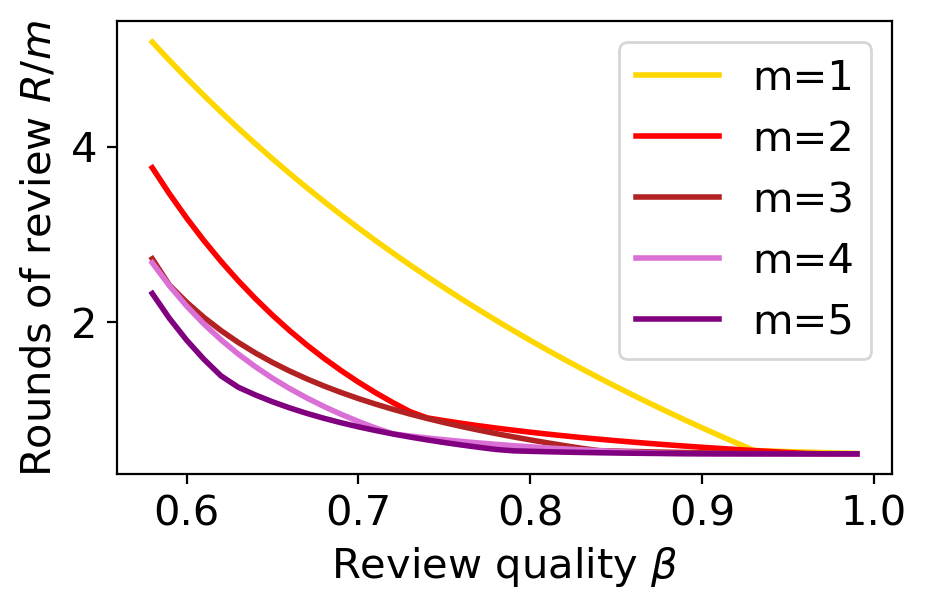

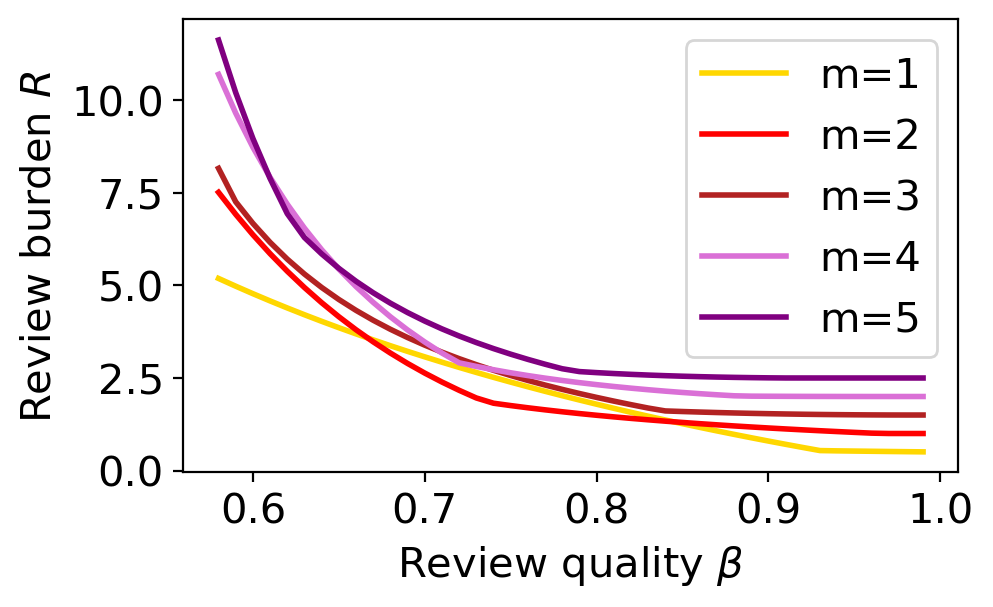

In [36]:
"""
Review burden vs lambda for different m
"""
Colors = ['gold','red','firebrick','orchid','purple']
eta = 0.7 # the discount factor
V = 5 # conference value
p = 0.5 # prior of good papers
beta_range = np.arange(0.58,1,0.01) # Sample the review quality
R = np.zeros((len(beta_range),5)) # Record the review burden
Num_rounds = np.zeros((len(beta_range),5)) # Record the number of rounds (review burden/m)

for j,beta in enumerate(beta_range):
    for m in [1,2,3,4,5]:
        l_star, phi = opt_strategy(eta,V,m,beta) # Compute the optimal threshold
        P_acc_g = 0 # The probability of a good paper being accepted in one round
        if l_star == m:
            P_acc_g = phi*review_prob_f(m,m,beta)
        else:
            P_acc_g = review_prob_F(m,l_star+1,beta) + phi*review_prob_f(m,l_star,beta)
        Num_rounds[j,m-1] = p/P_acc_g # If a good paper is accepted with P_acc_g probability, the expected number of rounds for its acceptance can be computed
        R[j,m-1] = m*p/P_acc_g # review burden = number of review rounds * m
        
# Plotting the curves
plt.figure(figsize=(5,3), dpi= 200)
for m in [1,2,3,4,5]:
    plt.plot(beta_range,Num_rounds[:,m-1],color=Colors[m-1],label = 'm='+str(m),linewidth=2)
legend2 = plt.legend(fontsize=15)
plt.xlabel(r'Review quality $\beta$', fontsize=15)
plt.ylabel(r'Rounds of review $R/m$', fontsize=15)
plt.tick_params(labelsize=15)

plt.figure(figsize=(5,3), dpi= 200)
for m in [1,2,3,4,5]:
    plt.plot(beta_range,R[:,m-1],color=Colors[m-1],label = 'm='+str(m),linewidth=2)
legend2 = plt.legend(fontsize=15)
plt.xlabel(r'Review quality $\beta$', fontsize=15)
plt.ylabel(r'Review burden $R$', fontsize=15)
plt.tick_params(labelsize=15)

## 1.2 The optimal number of solicited reviews

Text(0.5, 1.0, 'Minimal review burden')

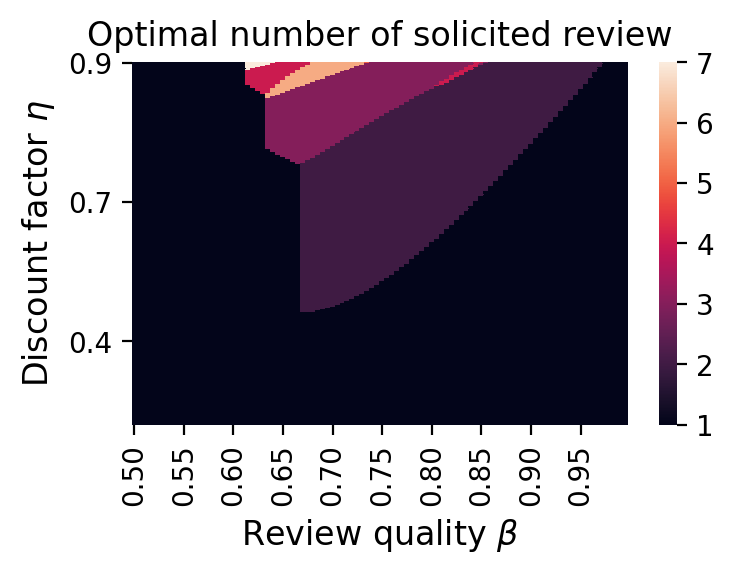

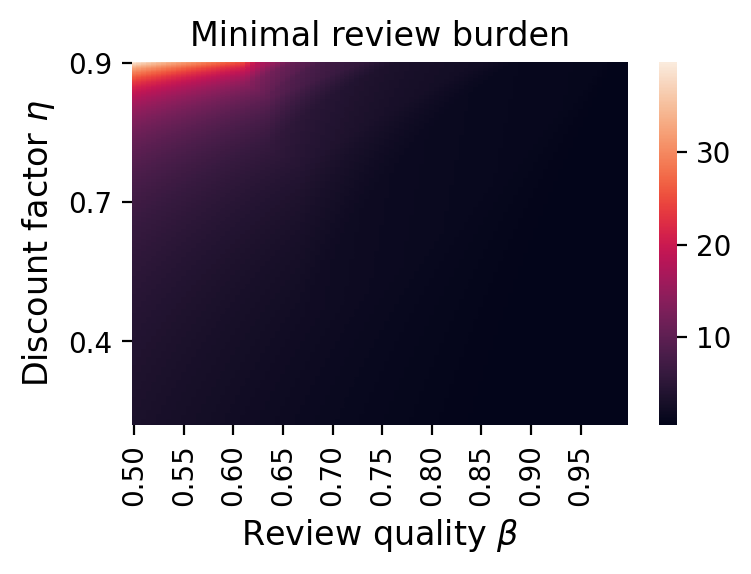

In [68]:
"""
Effect of discount rate
Solve for the optimal number of solicited reviews under different eta and beta.
An m is optimal if it leads to the minimum review burden while guaranteeing the optimal conference quality.
"""

p = 0.5 # Prior of paper quality
V = 5 # Conference value
eta_range = np.arange(0.3,0.95,0.001) # Sample the discount factor
beta_range = np.arange(0.5,1,0.005) # Sample the review quality
opt_m = np.zeros((len(eta_range),len(beta_range))) # Record the optimal m 
opt_R = np.zeros((len(eta_range),len(beta_range))) # Record the review burden
for i,eta in enumerate(eta_range):
    for j,beta in enumerate(beta_range):
        R = [] # For each pair of eta and beta, record the review burden given different m
        for m in [1,2,3,4,5,6,7,8]:
            l_star, phi = opt_strategy(eta,V,m,beta)
            P_acc_g = 0
            if l_star == m:
                P_acc_g = phi*review_prob_f(m,m,beta)
            else:
                P_acc_g = review_prob_F(m,l_star+1,beta) + phi*review_prob_f(m,l_star,beta)
            R.append(m*p/P_acc_g)
        opt_m[-i-1,j] = np.argmin(R) + 1
        opt_R[-i-1,j] = np.min(R)
        
df = pd.DataFrame(opt_m, index=list(np.flip(eta_range)) ,columns=list(beta_range))
plt.figure(figsize=(4,2.4), dpi= 200)
fig = sns.heatmap(df,xticklabels=10,yticklabels=250,zorder=1)
fmt = '{:0.2f}'
xticklabels = []
for item in fig.get_xticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    xticklabels += [item]

fmt = '{:0.1f}'
yticklabels = []
for item in fig.get_yticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    yticklabels += [item]

fig.set_xticklabels(xticklabels)
fig.set_yticklabels(yticklabels)
plt.xlabel(r'Review quality $\beta$',fontsize = 12)
plt.ylabel(r'Discount factor $\eta$',fontsize = 12)
plt.title('Optimal number of solicited review',fontsize = 12)



df = pd.DataFrame(opt_R, index=list(np.flip(eta_range)) ,columns=list(beta_range))
plt.figure(figsize=(4,2.4), dpi= 200)
fig = sns.heatmap(df,xticklabels=10,yticklabels=250,zorder=1)
fmt = '{:0.2f}'
xticklabels = []
for item in fig.get_xticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    xticklabels += [item]

fmt = '{:0.1f}'
yticklabels = []
for item in fig.get_yticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    yticklabels += [item]

fig.set_xticklabels(xticklabels)
fig.set_yticklabels(yticklabels)
plt.xlabel(r'Review quality $\beta$',fontsize = 12)
plt.ylabel(r'Discount factor $\eta$',fontsize = 12)
plt.title('Minimal review burden',fontsize = 12)


In [73]:
"""
Effect of conference value
Solve for the optimal number of solicited reviews under different eta and beta.
An m is optimal if it leads to the minimum review burden while guaranteeing the optimal conference quality.
--------------
This takes about 3 min to run.
"""

p = 0.5 # Prior of paper quality
eta = 0.7 # The discount factor
V_range = np.arange(1.1,30,0.02) # Sample the conference value
beta_range = np.arange(0.5,1,0.005) # Sample the review quality
opt_m = np.zeros((len(V_range),len(beta_range))) # Record the optimal m 
opt_R = np.zeros((len(V_range),len(beta_range))) # Record the review burden=
for i,V in enumerate(V_range):
    for j,beta in enumerate(beta_range):
        R = [] # For each pair of V and beta, record the review burden given different m
        for m in [1,2,3,4,5,6,7,8]:
            l_star, phi = opt_strategy(eta,V,m,beta)
            P_acc_g = 0
            if l_star == m:
                P_acc_g = phi*review_prob_f(m,m,beta)
            else:
                P_acc_g = review_prob_F(m,l_star+1,beta) + phi*review_prob_f(m,l_star,beta)
            R.append(m*p/P_acc_g)
        opt_m[-i-1,j] = np.argmin(R) + 1
        opt_R[-i-1,j] = np.min(R)

Text(41.44444444444443, 0.5, 'Conference value $V$')

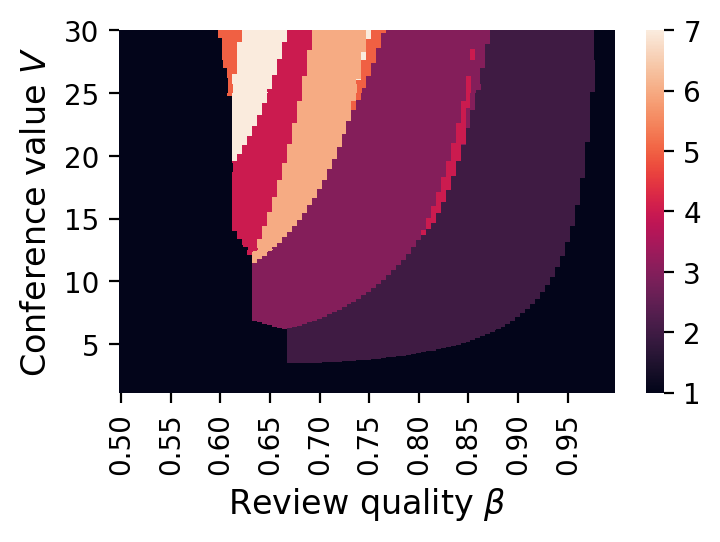

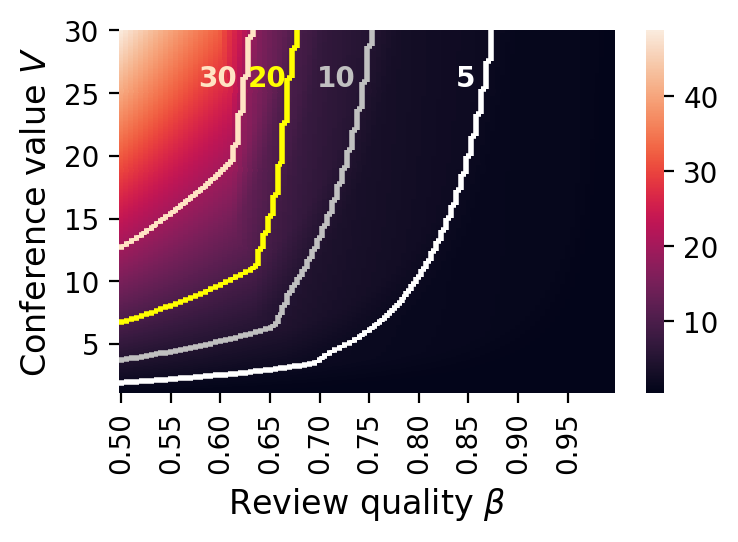

In [74]:
def add_iso_line(fig, value, color):
    """
    Input: "fig" is the figure to plot contours;
           "value" is the value of the contour;
           "color" indicates the name of the color of the contour.
    The function will draw the countour on the input figure
    """
    v = df.gt(value).diff(axis=1).fillna(False).to_numpy()
    h = df.gt(value).diff(axis=0).fillna(False).to_numpy()

    l = np.argwhere(v.T)    
    vlines = np.array(list(zip(l, np.stack((l[:,0], l[:,1]+1)).T)))

    l = np.argwhere(h.T)    
    hlines = np.array(list(zip(l, np.stack((l[:,0]+1, l[:,1])).T)))

    lines = np.vstack((vlines, hlines))
    fig.add_collection(LineCollection(lines, lw=2, colors=color ))

df = pd.DataFrame(opt_m, index=list(np.flip(V_range)) ,columns=list(beta_range))
plt.figure(figsize=(4,2.4), dpi= 200)
fig = sns.heatmap(df,xticklabels=10,yticklabels=250,zorder=1)
fmt = '{:0.2f}'
xticklabels = []
for item in fig.get_xticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    xticklabels += [item]

fmt = '{:0.0f}'
yticklabels = []
for item in fig.get_yticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    yticklabels += [item]
    
fig.set_xticklabels(xticklabels)
fig.set_yticklabels(yticklabels)
plt.xlabel(r'Review quality $\beta$',fontsize = 12)
plt.ylabel(r'Conference value $V$',fontsize = 12)



df = pd.DataFrame(opt_R, index=list(np.flip(V_range)) ,columns=list(beta_range))
plt.figure(figsize=(4,2.4), dpi= 200)
fig = sns.heatmap(df,xticklabels=10,yticklabels=250,zorder=1)
fmt = '{:0.2f}'
xticklabels = []
for item in fig.get_xticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    xticklabels += [item]

fmt = '{:0.0f}'
yticklabels = []
for item in fig.get_yticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    yticklabels += [item]

# Plot contours
add_iso_line(fig, 2, 'white')
add_iso_line(fig, 5, 'silver')
add_iso_line(fig, 10, 'yellow')
add_iso_line(fig, 20, 'bisque')

plt.text(68, 190, '5', va='center',color = 'white',weight='bold',fontsize = 10)
plt.text(40, 190, '10', va='center',color = 'silver',weight='bold',fontsize = 10)
plt.text(26, 190, '20', va='center',color = 'yellow',weight='bold',fontsize = 10)
plt.text(16, 190, '30', va='center',color = 'bisque',weight='bold',fontsize = 10)

fig.set_xticklabels(xticklabels)
fig.set_yticklabels(yticklabels)
plt.xlabel(r'Review quality $\beta$',fontsize = 12)
plt.ylabel(r'Conference value $V$',fontsize = 12)


# 2. Noisy Agents

Results in this section are solved with our agent-based model. For short, we call the authors Alice and the conference Bob.

## 2.1 Agents based model setup

In [168]:
"""
Parameters
"""
n = 10000 # number of Alices
p = 0.5 # prior of good paper
alpha = 0.8 # Given paper quality q, with probablity alpha Alice sees a signal of q
beta = 0.7 # Given paper quality q, with probablity beta Bob sees a high signal
m = 4 # Number of reviews each turn
l = 3 # Minimum number of good reviews for acceptance
L = [m,2*m-1,3*m-2] # the accumulated number of positive reviews for acceptance at each round with historical reviews following
gamma = [0.05, 0.95] # For naive strategy, the probability that Alice will submit while seeting a low/high signal
eta = 0.7 # Discount factor
V = 5 # Reward of getting a paper accepted by the high conference (high conference)

def initialization(Bob_policy):
    """
    Initialize the ABM given the conference policy
    """
    global quality, S, papers, reviews_his, acceptance_his, utility, State_utility, State_policy
    quality = np.array(random.choices([0, 1], [1-p, p], k = n)) # Ground truth quality of the papers, binary
    S = np.zeros(n) # Authors' signals
    S[np.where(quality == 1)[0]] = np.array(random.choices([0,1], [1-alpha,alpha], k = len(np.where(quality == 1)[0])))
    S[np.where(quality == 0)[0]] = np.array(random.choices([0,1], [alpha,1-alpha], k = len(np.where(quality == 0)[0])))
    papers = np.zeros(n) # The status of papers, with 0 to be submitted, 1 submitted, 2 accepted and 3 submitted to low conference
    reviews_his = [[] for i in range(n)] # The review history of each paper, recording the number of good/bad review each round
    acceptance_his = [] # The accpetance history of Bob, recording the number of accpeted/rejected good/bad papers each round
    utility= np.zeros(n) # The eventually utility of each paper
    
    # initialize and compute the state-to-policy and state-to-optimal_utility mappings
    # The state is determined by (K, G, S) where K is the total number of reviews, G is the accumulated number of 
    # positive reviews, and S is the author's private signal.
    State_utility = {}
    for i in range(T*m+1):
        for Si in [0,1]:
            State_utility[(T*m,i,Si)] = np.power(eta, T)
    State_policy = {}
    for i in range(T*m+1):
        for Si in [0,1]:
            State_policy[(T*m,i,Si)] = 0
    Alice_best_responce(Bob_policy)
    
def update(Bob_policy):
    """
    Update the ABM 
    """
    Alice_strategy_optimal(Bob_policy)
        
    if Bob_policy == 0: # T-round, fixed-threshold policy
        Bob_policy_fixed_threshold(l_star, phi)
    elif Bob_policy == 1: # T-round, variable-threshold policy
        Bob_policy_variable_threshold(L_star, Phi)
    elif Bob_policy == 2: # the review-following policy
        Bob_policy_review_following(L_star, Phi)

def Probability_acc(t, gt, Gt, Bob_policy):
    """
    Input: "t" is the current number of rounds;
           "gt" is the number of positive reiviews at the current round t;
           "Gt" is the accumulated number of positive reviews at round t;
           "Bob_strategy" indicates the type of acceptance strategy of the conference.
    Output: the acceptance probability.
    """
    # T-round, fixed-threshold policy
    if Bob_policy == 0:
        if gt > l_star:
            return 1
        elif gt < l_star:
            return 0
        else:
            return phi
    # T-round, variable-threshold policy
    elif Bob_policy == 1:
        if gt > L_star[t]:
            return 1
        elif gt < L_star[t]:
            return 0
        else:
            return Phi[t]
    # the review-following policy
    elif Bob_policy == 2:
        if Gt > L_star[t]:
            return 1
        elif Gt < L_star[t]:
            return 0
        else:
            return Phi[t]
    
    
############## Author (Alice)
    
def Probability_good(Kt, Gt, Si):
    """
    Input: "Kt" is the total number of reviews;
           "Gt" is the accumulated number of positive reviews;
           "Si" is the author's private signal.
    Output: the probability of the paper being a good one conditional on the reviews and the private signal.
    """
    return (p*np.power(alpha, Si)*np.power(1-alpha, 1-Si)*np.power(beta, Gt)*np.power(1-beta, Kt-Gt))/(p*np.power(alpha, Si)*np.power(1-alpha, 1-Si)*np.power(beta, Gt)*np.power(1-beta, Kt-Gt)+(1-p)*np.power((1-alpha), Si)*np.power((alpha), 1-Si)*np.power(1-beta, Gt)*np.power(beta, Kt-Gt))

def Alice_best_responce(Bob_policy):
    """
    The function computes the author's best response given the conference's policy with a dynamic programming.
    The state is determined by (K, G, S) where K is the total number of reviews, G is the accumulated number of 
    positive reviews, and S is the author's private signal.
    The function computes a mapping from a state to the optimal action at that state, "State_policy": 0 to submit
    to the sure bet and 1 to submit to Bob; 
    The function also computes a mapping from a state to the optimal expected utility at that state, "State_utility". 
    """
    for Si in [0,1]:
        for t in range(T-1, -1, -1): # Compute the optimal expected utility in backward manner;
            for g in range(t*m+1):
                P_good = Probability_good(t*m, g, Si) # The probability of the paper being good given the current state;
                E_u = 0
                for dg in range(m+1):
                    # "P_review" is the probability of seeting "dg" positive reviews given the current state;
                    P_review = P_good*comb(m,dg)*np.power(beta,dg)*np.power(1-beta, m-dg) + (1-P_good)*comb(m,dg)*np.power(1-beta,dg)*np.power(beta, m-dg)
                    P_acc = Probability_acc(t, dg, g+dg, Bob_policy)
                    E_u += P_review*(P_acc*V*np.power(eta, t) + (1-P_acc)*State_utility[((t+1)*m, g+dg, Si)])
                if E_u >= np.power(eta,t): # if submitting to Bob is optimal
                    State_utility[(t*m,g,Si)] = E_u
                    State_policy[(t*m,g,Si)] = 1
                else: # if submit to the sure bet is optimal
                    State_utility[(t*m,g,Si)] = np.power(eta,t)
                    State_policy[(t*m,g,Si)] = 0

def Alice_strategy_optimal(Bob_strategy):
    """
    The function will update the status of each paper by deciding whether it will be submitted to Bob in the next 
    round, given the authors' best response mapping.
    """
    for i in np.where(papers == 0)[0]: # for every paper that has not been accepted by either Bob or the sure bet option
        if reviews_his[i] == []: # if the paper has not been submitted
            cumulated_count = [0,0]
        else:
            cumulated_count = np.sum(np.array(reviews_his[i]), axis = 0)
        policy = State_policy[(cumulated_count[0]+cumulated_count[1], cumulated_count[1], S[i])]
        if policy == 0:
            papers[i] = 3
            times = len(reviews_his[i])
            utility[i] += np.power(eta, times)
        elif policy == 1:
            papers[i] = 1
            
            
############## Conference (Bob)
    
def Bob_policy_fixed_threshold(l_star, phi): 
    """
    This function draws iid reviews for a new round and makes the accept/reject decision based on the conference policy.
    Papers' status and conference's review history and acceptance history are then updated.
    """
    acceptance = np.zeros(4) # Numebr of good acc, good rej, bad acc, bad rej
    for i in np.where(papers == 1)[0]: # for every submitted paper
        # Draw m iid reviews
        if quality[i] == 0:
            review = random.choices([0,1], [beta,1-beta], k = m)
        else:
            review = random.choices([0,1], [1-beta,beta], k = m)
        count = [len(np.where(np.array(review) == 0)[0]), len(np.where(np.array(review) == 1)[0])]
        
        # if the number of positive reviews is larger then l_star, then accept
        if count[1] > l_star:
            papers[i] = 2
            times = len(reviews_his[i])
            utility[i] += V*np.power(eta, times)
            if quality[i] == 0:
                acceptance[2] += 1
            else:
                acceptance[0] += 1
        # if the number of positive reviews is smaller then l_star, then reject
        elif count[1] < l_star:
            papers[i] = 0
            if quality[i] == 0:
                acceptance[3] += 1
            else:
                acceptance[1] += 1
        # if the number of positive reviews is equal to l_star, then accept with probability phi
        else:
            random_seed = random.uniform(0, 1)
            if random_seed <= phi:
                papers[i] = 2
                times = len(reviews_his[i])
                utility[i] += V*np.power(eta, times)
                if quality[i] == 0:
                    acceptance[2] += 1
                else:
                    acceptance[0] += 1
        reviews_his[i].append(count)
    acceptance_his.append(acceptance)
    
def Bob_policy_variable_threshold(L_star, Phi):
    """
    This function draws iid reviews for a new round and makes the accept/reject decision based on the conference policy.
    Papers' status and conference's review history and acceptance history are then updated.
    """
    acceptance = np.zeros(4) # Numebr of good acc, good rej, bad acc, bad rej
    for i in np.where(papers == 1)[0]:
        if quality[i] == 0:
            review = random.choices([0,1], [beta,1-beta], k = m)
        else:
            review = random.choices([0,1], [1-beta,beta], k = m)
        count = [len(np.where(np.array(review) == 0)[0]), len(np.where(np.array(review) == 1)[0])]
        rounds = len(reviews_his[i])
        if count[1] > L_star[rounds]:
            papers[i] = 2
            utility[i] += V*np.power(eta, rounds)
            if quality[i] == 0:
                acceptance[2] += 1
            else:
                acceptance[0] += 1
        elif count[1] < L_star[rounds]:
            papers[i] = 0
            if quality[i] == 0:
                acceptance[3] += 1
            else:
                acceptance[1] += 1
        else:
            random_seed = random.uniform(0, 1)
            if random_seed <= Phi[rounds]:
                papers[i] = 2
                times = len(reviews_his[i])
                utility[i] += V*np.power(eta, rounds)
                if quality[i] == 0:
                    acceptance[2] += 1
                else:
                    acceptance[0] += 1
        reviews_his[i].append(count)
    acceptance_his.append(acceptance)
    
def Bob_policy_review_following(L_star, Phi):
    """
    This function draws iid reviews for a new round and makes the accept/reject decision based on the conference policy.
    Papers' status and conference's review history and acceptance history are then updated.
    """
    acceptance = np.zeros(4) # Numebr of good acc, good rej, bad acc, bad rej
    for i in np.where(papers == 1)[0]:
        if quality[i] == 0:
            review = random.choices([0,1], [beta,1-beta], k = m)
        else:
            review = random.choices([0,1], [1-beta,beta], k = m)
        count = [len(np.where(np.array(review) == 0)[0]), len(np.where(np.array(review) == 1)[0])]
        if reviews_his[i] == []:
            cumulated_count = np.array(count)
        else:
            cumulated_count = np.sum(np.array(reviews_his[i]), axis = 0) + np.array(count)
        rounds = len(reviews_his[i])
        if cumulated_count[1] > L_star[rounds]:
            papers[i] = 2
            utility[i] += V*np.power(eta, rounds)
            if quality[i] == 0:
                acceptance[2] += 1
            else:
                acceptance[0] += 1
        elif cumulated_count[1] < L_star[rounds]:
            papers[i] = 0
            if quality[i] == 0:
                acceptance[3] += 1
            else:
                acceptance[1] += 1
        else:
            random_seed = random.uniform(0, 1)
            if random_seed <= Phi[rounds]:
                papers[i] = 2
                times = len(reviews_his[i])
                utility[i] += V*np.power(eta, rounds)
                if quality[i] == 0:
                    acceptance[2] += 1
                else:
                    acceptance[0] += 1
        reviews_his[i].append(count)
    acceptance_his.append(acceptance)



## 2.2. QB-tradeoff

In [188]:
def Pareto_optimal(U_C,R):
    """
    Input: "U_C" is a list of conference quality;
           "R" is a list of review burden with equal length of "U_C";
           The i'th entry of both vectors result in a point on the QB-tradeoff.
    Output: the Pareto optimal points on the input points on the QB-tradeoff.
    """
    U_C = np.round(np.array(U_C),4)
    R = np.round(np.array(R),4)
    left = []
    length = len(U_C)
    for i in range(length):
        if R[i] == 0:
            continue
        flag = 0
        for j in range(length):
            if j != i:
                if (U_C[i] < U_C[j] and R[i] >= R[j]) or (U_C[i] <= U_C[j] and R[i] > R[j]):
                    flag = 1
                    break
        if flag == 0:
            left.append(i)
    return U_C[np.array(left)], R[np.array(left)], np.array(left)

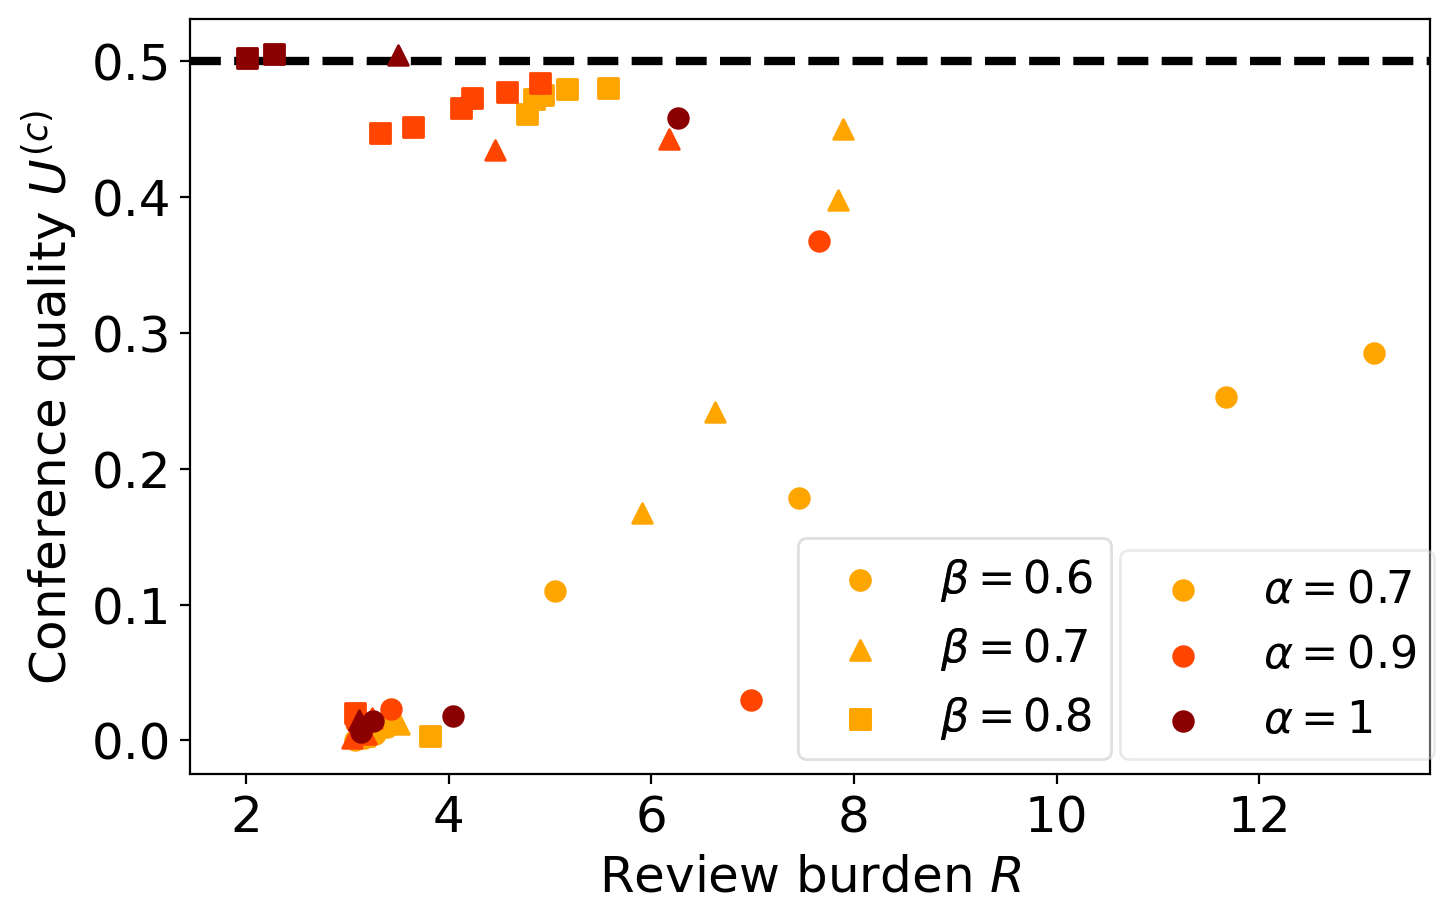

In [100]:
"""
Fixing m, varying alpha and beta
---------------
This takes about 3 min to run
"""
V = 5
eta = 0.7
n = 10000
p = 0.5
m = 3
T = 10
color = ['orange','orangered','darkred']
Line = ['-','--','-.']
Marker = ['o','^','s']

plt.figure(figsize=(8,5), dpi= 200)
for i,alpha in enumerate([0.7,0.9,1]):
    for h,beta in enumerate([0.6,0.7,0.8]):
        Uc = []
        R = []
        for l_star in range(m,-1,-1):
            for phi in np.arange(0,1,0.1):
                initialization(0)
                for t in range(T):
                    update(0)
                    
                # After T rounds, unaccepted papers will be submitted to the sure bet
                utility[np.where(papers==0)[0]] += np.power(eta, T) 
                papers[np.where(papers==0)[0]] = 3
                
                # Compute the conference quality
                acc_good = np.count_nonzero(papers[quality == 1] == 2) # number of accepted good papers
                acc_bad = np.count_nonzero(papers[quality == 0] == 2) # number of accepted bad papers
                Uc.append((acc_good - acc_bad)/n)
                
                # Compute the review burden
                num_round = np.zeros(n)
                for j in range(n):
                    num_round[j] = len(reviews_his[j])
                R.append(np.average(num_round)*m)
        Uc_po, R_po,_ = Pareto_optimal(Uc,R)
        if i == 0 and h == 0:
            A_06_B_06 = plt.scatter(R_po, Uc_po, color = color[i], s = 50, marker=Marker[h])
        elif i == 1 and h == 0:
            A_08_B_06 = plt.scatter(R_po, Uc_po, color = color[i], s = 50, marker=Marker[h])
        elif i == 2 and h == 0:
            A_10_B_06 = plt.scatter(R_po, Uc_po, color = color[i], s = 50, marker=Marker[h])
        elif i == 0 and h == 1:
            A_06_B_08 = plt.scatter(R_po, Uc_po, color = color[i], s = 50, marker=Marker[h])
        elif i == 0 and h == 2:
            A_06_B_10 = plt.scatter(R_po, Uc_po, color = color[i], s = 50, marker=Marker[h])
        else:
            plt.scatter(R_po, Uc_po, color = color[i], s = 50, marker=Marker[h])
        
legend1 = plt.legend([A_06_B_06,A_08_B_06,A_10_B_06], [r'$\alpha=0.7$',r'$\alpha=0.9$',r'$\alpha=1$'], fontsize=16, loc = (0.75,0.02),framealpha = 0.4)
legend2 = plt.legend([A_06_B_06,A_06_B_08,A_06_B_10], [r'$\beta=0.6$',r'$\beta=0.7$',r'$\beta=0.8$'], fontsize=16, loc = (0.49,0.02),framealpha = 0.4)
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)
plt.xlabel(r'Review burden $R$', fontsize=18)
plt.ylabel(r'Conference quality $U^{(c)}$', fontsize=18)
plt.tick_params(labelsize=18)
plt.axhline(y=0.5, color='black', linestyle='--', linewidth = 3,zorder=0)


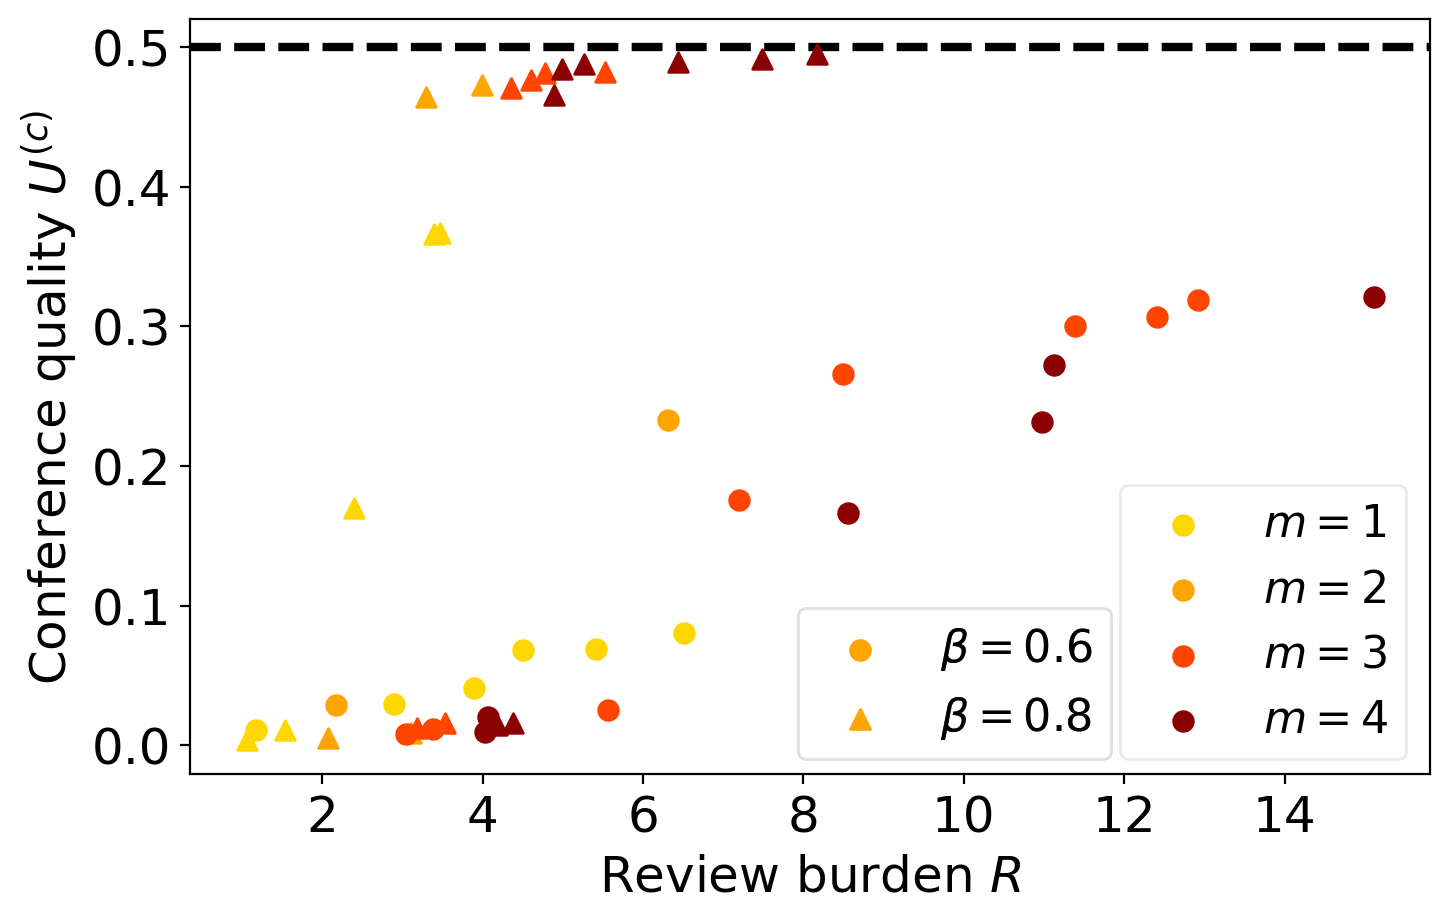

In [101]:
"""
Fixing alpha, varying m and beta
---------------
This takes about 3 min to run
"""
V = 5
eta = 0.7
alpha = 0.8
n = 10000
p = 0.5
T = 10
color = ['gold','orange','orangered','darkred']
Line = ['-','--','-.']
Marker = ['o','^','s']

plt.figure(figsize=(8,5), dpi= 200)
for i,m in enumerate([1,2,3,4]):
    for h,beta in enumerate([0.6,0.8]):
        Uc = []
        R = []
        for l_star in range(m,-1,-1):
            for phi in np.arange(0,1,0.1):
                # Memoryless policy
                initialization(0)
                for t in range(T):
                    update(0)
                    
                # After T rounds, unaccepted papers will be submitted to the sure bet
                utility[np.where(papers==0)[0]] += np.power(eta, T) 
                papers[np.where(papers==0)[0]] = 3

                acc_good = np.count_nonzero(papers[quality == 1] == 2)
                acc_bad = np.count_nonzero(papers[quality == 0] == 2)
                Uc.append((acc_good - acc_bad)/n)
                num_round = np.zeros(n)
                for j in range(n):
                    num_round[j] = len(reviews_his[j])
                R.append(np.average(num_round)*m)
        
        Uc_po, R_po,_ = Pareto_optimal(Uc,R)
        if h == 0:
            if i == 0:
                M1 = plt.scatter(R_po, Uc_po, color = color[i], s = 50, marker=Marker[h])
            elif i == 1:
                M2 = plt.scatter(R_po, Uc_po, color = color[i], s = 50, marker=Marker[h])
            elif i == 2:
                M3 = plt.scatter(R_po, Uc_po, color = color[i], s = 50, marker=Marker[h])
            elif i == 3:
                M4 = plt.scatter(R_po, Uc_po, color = color[i], s = 50, marker=Marker[h])
        else:
            if i == 1:
                B_08 = plt.scatter(R_po, Uc_po, color = color[i], s = 50, marker=Marker[h])
            else:
                plt.scatter(R_po, Uc_po, color = color[i], s = 50, marker=Marker[h])
        
legend1 = plt.legend([M1, M2, M3, M4], [r'$m=1$',r'$m=2$',r'$m=3$',r'$m=4$'], fontsize=16, loc = (0.75,0.02),framealpha = 0.4)
legend2 = plt.legend([M2,B_08], [r'$\beta=0.6$',r'$\beta=0.8$'], fontsize=16, loc = (0.49,0.02),framealpha = 0.4)
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)
plt.xlabel(r'Review burden $R$', fontsize=18)
plt.ylabel(r'Conference quality $U^{(c)}$', fontsize=18)
plt.tick_params(labelsize=18)
plt.axhline(y=0.5, color='black', linestyle='--', linewidth = 3,zorder=0)


## 2.3. Acceptance rate

In [109]:
"""
This takes about 15 min to run.
"""

def transfer(tau,m,p,beta):
    """
    Input: "tau" is the acceptance threshold in the posterior space;
           "m" is the number of solicited reviews;
           "p" is the prior of good paper;
           "beta" is the review quality.
    The function transfers the acceptance threshold in the posterior space into the acceptance threshold in the 
    form of (l_star, phi).
    """
    l_star = np.where(U_list >= tau)[0][0]
    phi = (U_list[l_star]-tau)/(U_list[l_star]-U_list[l_star-1])   
    return l_star, phi

V = 5
eta = 0.7
n = 10000
p = 0.5
m = 3
T = 10

# "U_list" is a pre-computed vector of the expected paper qualities conditionl of every possible combination of reviews (there are m+1 in total).
U_list = np.zeros(m+1)
for i in range(m+1): # i out of m reviews are positive reviews
    # "P_g" is the probability of the paper being a good one conditional on the reviews
    P_g = p*np.power(beta,i)*np.power(1-beta,k-i)/(p*np.power(beta,i)*np.power(1-beta,k-i)+(1-p)*np.power(1-beta,i)*np.power(beta,k-i))
    U_list[i] = 2*P_g - 1 # expected quality
    
tau_range = np.arange(U_list[0],U_list[k],0.01)
Acc_rate = np.zeros((3,2,len(tau_range)))
color = ['gold','orange','orangered','firebrick','darkred']

for i,alpha in enumerate([0.6,0.75,0.9]):
    for j,beta in enumerate([0.7,0.9]):
        for l,tau in enumerate(tau_range):
            l_star, phi = transfer(tau,k,p,beta) 
            initialization(0)
            for t in range(T):
                update(0)
            utility[np.where(papers==0)[0]] += np.power(eta, T)
            papers[np.where(papers==0)[0]] = 3
            
            n_submit = 0
            for h in range(n):
                n_submit += len(reviews_his[h]) # Counting the total number of submissions
            if n_submit != 0:
                Acc_rate[i,j,l] = np.count_nonzero(papers == 2)/n_submit



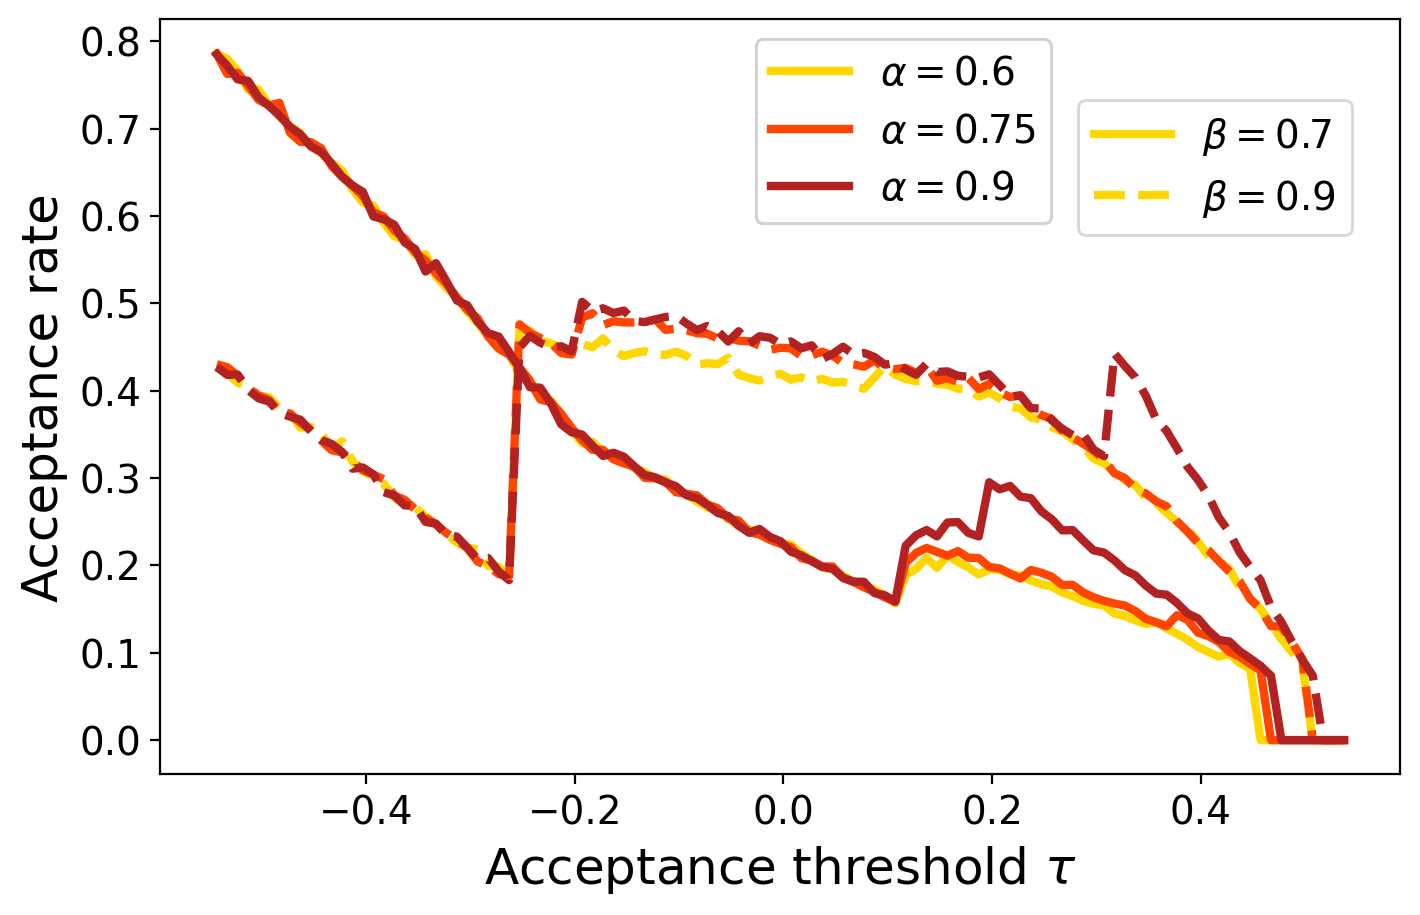

In [110]:
Colors = ['gold','orangered','firebrick']
Lines = ['-','--','-.']

plt.figure(figsize=(8,5), dpi= 200)

for i,alpha in enumerate([0.6,0.75,0.9]):
    for j,beta in enumerate([0.7,0.9]):
        if i == 0 and j == 0:
            A06_B06 ,= plt.plot(tau_range, Acc_rate[i,j], linestyle = Lines[j], color = Colors[i], linewidth = 3)
        elif i == 0 and j == 1:
            A06_B075 ,= plt.plot(tau_range, Acc_rate[i,j], linestyle = Lines[j], color = Colors[i], linewidth = 3)
        elif i == 1 and j == 0:
            A075_B06 ,= plt.plot(tau_range, Acc_rate[i,j], linestyle = Lines[j], color = Colors[i], linewidth = 3)
        elif i == 2 and j == 0:
            A09_B06 ,= plt.plot(tau_range, Acc_rate[i,j], linestyle = Lines[j], color = Colors[i], linewidth = 3)
        else:
            plt.plot(tau_range, Acc_rate[i,j], linestyle = Lines[j], color = Colors[i], linewidth = 3)

plt.tick_params(labelsize=14)
plt.xlabel(r'Acceptance threshold $\tau$', fontsize = 18)
plt.ylabel(r'Acceptance rate', fontsize = 18)

legend1 = plt.legend([A06_B06, A06_B075, A06_B09], [r'$\beta=0.7$', r'$\beta=0.9$'], fontsize=14, loc = (0.74,0.715))
legend2 = plt.legend([A06_B06, A075_B06, A09_B06], [r'$\alpha=0.6$', r'$\alpha=0.75$', r'$\alpha=0.9$'], fontsize=14, loc = (0.48,0.73))
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)

## 2.4. Heatmap

We present a different view of the QB-tradeoff, where we use a heatmap to capture the largest conference quality that can be achieved given a review quality and review burden.

In [ ]:
"""
Results are saved, can skip this cell
"""
alpha = 0.8
beta_range = np.arange(0.55,1,0.01)
V = 5
eta = 0.7
T = 10
Uc = []
R = []
for h,beta in enumerate(beta_range):
    print(beta)
    Uc_m = []
    R_m = []
    
    # for each of the review quality, sample different m
    for m in [1,2,3,4,5]:
        # sample the acceptance threshold
        for l_star in range(m,-1,-1):
            for phi in np.arange(0,1,0.1):
                initialization(0)
                for t in range(T):
                    update(0)
                utility[np.where(papers==0)[0]] += np.power(eta, T) 
                papers[np.where(papers==0)[0]] = 3
                
                acc_good = np.count_nonzero(papers[quality == 1] == 2)
                acc_bad = np.count_nonzero(papers[quality == 0] == 2)
                Uc_m.append((acc_good - acc_bad)/n)
                num_round = np.zeros(n)
                for j in range(n):
                    num_round[j] = len(reviews_his[j])
                R_m.append(np.average(num_round)*m)
        
    Uc.append(Uc_m)
    R.append(R_m)
    
Uc = np.array(Uc)
R = np.array(R)
# np.save('Results/Heatmap_binary/heatmap2_alpha_'+str(alpha)+'_V_'+str(V)+'_eta_'+str(eta)+'_Uc.npy', Uc)
# np.save('Results/Heatmap_binary/heatmap2_alpha_'+str(alpha)+'_V_'+str(V)+'_eta_'+str(eta)+'_R.npy', R)

In [235]:
"""
Transform to heatmap data
"""
Uc = np.load('Results/Heatmap_binary/heatmap2_alpha_'+str(alpha)+'_V_'+str(V)+'_eta_'+str(eta)+'_Uc.npy')
R = np.load('Results/Heatmap_binary/heatmap2_alpha_'+str(alpha)+'_V_'+str(V)+'_eta_'+str(eta)+'_R.npy')

x_range = np.arange(0.55,1,0.01) # x-axis of the heatmap
y_range = np.arange(1,20.1,0.1) # y-axis of the heatmap
heatmap_data = np.zeros((len(y_range),len(x_range)))

### Generate heatmap
for i,x in enumerate(x_range):
    for j,y in enumerate(y_range):
        Uc_po, R_po, _ = Pareto_optimal(Uc[i],R[i]) # find the Pareto optimal points of the corresponding review quality
        R_sorted = np.sort(R_po) 
        index_sorted = np.argsort(R_po)
        index = np.where(R_sorted <= y)[0] # find the indexes of Pareto optimal points whose review burden is no larger than y
        if len(index) > 0:
            heatmap_data[-j,i] = Uc_po[index_sorted[index[-1]]] # the value of the heatmap at (x,y) is achieved by the Pareto optimal point with the largest review burden (conditional on review burden is no larger than y)
            
# if a point on the heatmap has higher review quality and larger review burden than another point, it should be able to achieve at least as much conference quality.
# However, because the sampling of tau is not sufficient enough, the resutls do not necessarily guarantee this. 
# The following codes fix it.
for i,x in enumerate(x_range):
    for j,y in enumerate(y_range):
        if i > 1 and j > 1:
            max_color = np.max(heatmap_data[-(j-1):,0:i-1])
            if heatmap_data[-j,i] < max_color:
                heatmap_data[-j,i] = max_color

Text(141.44444444444443, 0.5, 'Review burden $R$')

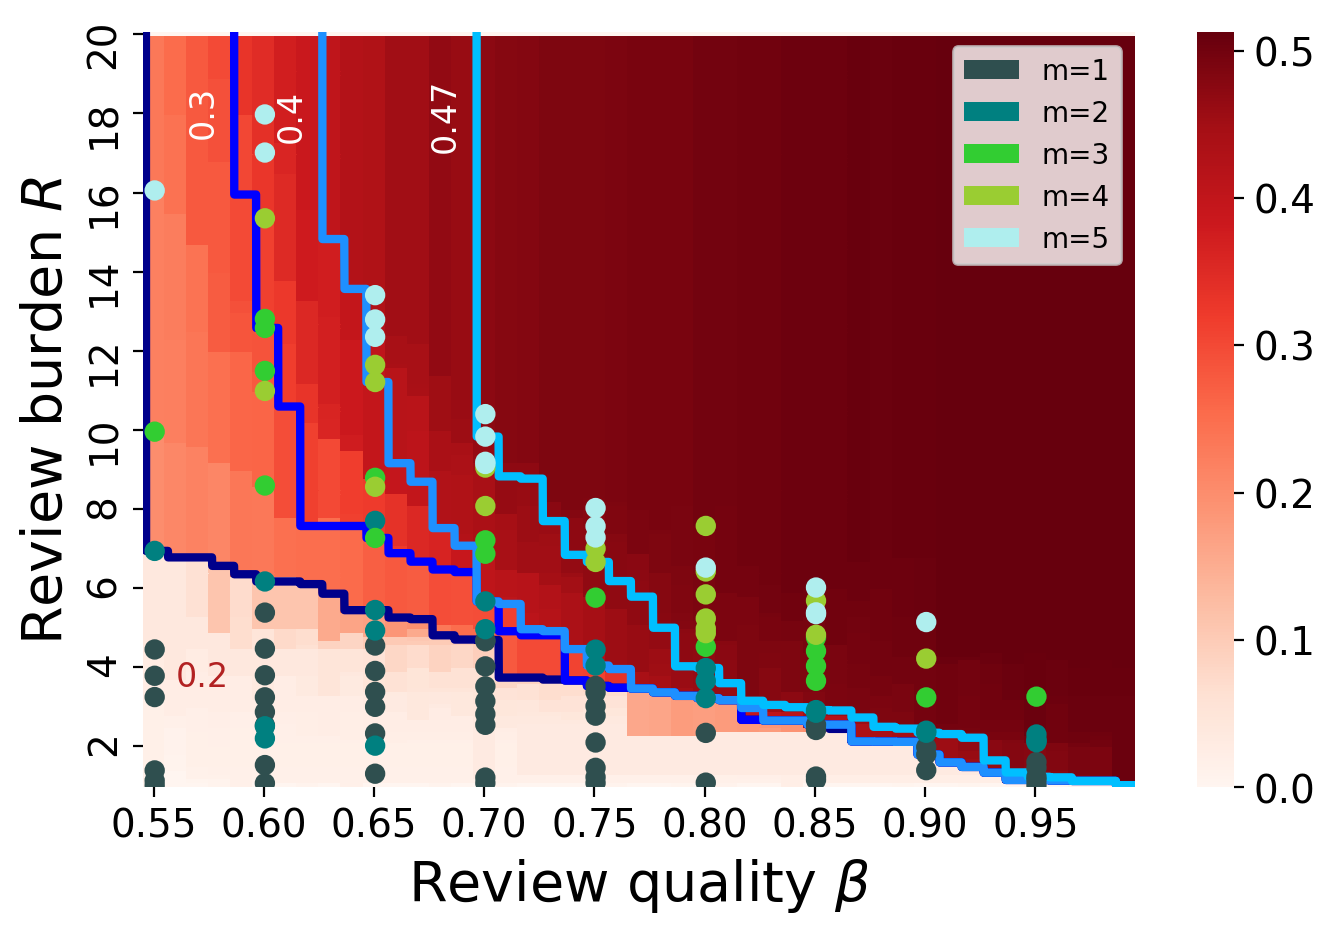

In [236]:
"""
Plot the heatmap
"""

def rearrange(x,y):
    """
    The function transforms the coordinates on heatmap into the coordinates on the scatter plot
    """
    return (x-0.5485)*100, (20.1-y)*10

plt.figure(figsize=(8,5), dpi= 200)
df = pd.DataFrame(heatmap_data, index=list(np.flip(np.round(y_range,2))) ,columns=list(np.round(x_range,2)))
fig = sns.heatmap(df,xticklabels=5,yticklabels=20,cmap = 'Reds', cbar=True)
cbar = fig.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)

fmt = '{:0.2f}'
xticklabels = []
for item in fig.get_xticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    xticklabels += [item]

fmt = '{:0.0f}'
yticklabels = []
for item in fig.get_yticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    yticklabels += [item]

fig.set_xticklabels(xticklabels,fontsize=14)
fig.set_yticklabels(yticklabels,fontsize=14)


### scatter the strategy points
m_list = [] # store the number of solicited reviews for each acceptance threshold
for m in [1,2,3,4,5]:
    for l_star in range(m,-1,-1):
        for phi in np.arange(0,1,0.1):
            m_list.append(m)

Beta = []
U_Bob = []
N_review = []
M_list = []
boundary = []
for b in range(len(beta_range)):
    if b%5 == 0:
        Uc_po, R_po, index = Pareto_optimal(Uc[b],R[b])
        for i in index:
            if Uc[b,i] != 0:
                Beta.append(beta_range[b])
                U_Bob.append(Uc[b,i])
                N_review.append(R[b,i])
                M_list.append(m_list[i])
M_list = np.array(M_list)
Beta_t, N_review_t = rearrange(np.array(Beta), np.array(N_review))
color_scatter = np.array(['darkslategrey','teal','limegreen','yellowgreen','paleturquoise'])
plt.scatter(Beta_t+0.4, N_review_t,
        s = 40,
        c = color_scatter[M_list-1],
        marker = 'o',
        zorder=2,
        label='k='+str(i))
legend_elements = [Patch(facecolor=color_scatter[i],label='m='+str(i+1)) for i in range(5)]
plt.legend(handles=legend_elements)

### Plot the contour
color_contour = ['cyan','deepskyblue','dodgerblue','blue','darkblue']
uc_list = [0.2,0.3,0.4,0.47]
x = np.arange(0.55,1,0.0001)
y_max = 25
y = np.ones((len(uc_list),len(x)))*y_max
for i,u_c in enumerate(uc_list):
    boundary = []
    for b in range(len(beta_range)):
        Uc_po, R_po, index = Pareto_optimal(Uc[b],R[b])
        if len(np.where(Uc_po >= u_c)[0]) > 0:
            if len(boundary) == 0:
                boundary.append([beta_range[b], np.min(R_po[np.where(Uc_po >= u_c)[0]])])
            elif np.min(R_po[np.where(Uc_po >= u_c)[0]]) <= boundary[-1][1]:
                boundary.append([beta_range[b], np.min(R_po[np.where(Uc_po >= u_c)[0]])])
    boundary_np = np.array(boundary)
    for b, beta in enumerate(x):
        where = np.where(boundary_np[:,0] < beta)[0]
        if len(where) > 0:
            index = where[-1]
            y[i,b] = boundary_np[index,1]
for i in range(len(uc_list)):
    x_t, y_t = rearrange(x,y[i])
    plt.plot(x_t,y_t,linewidth = 3,color = color_contour[-i-1],zorder=1)


### Name the contour
plt.text((0.565-0.55)*100, (22.1-5.8)*10, '0.2', va='center',color = 'firebrick', fontsize= 12)
plt.text((0.57-0.55)*100, (22.1-20.1)*10, '0.3', rotation=90, va='center',color = 'white', fontsize= 12)
plt.text((0.61-0.55)*100, (22.1-20)*10, '0.4', rotation=90, va='center',color = 'white', fontsize= 12)
plt.text((0.68-0.55)*100, (22.1-20)*10, '0.47', rotation=90, va='center',color = 'white', fontsize= 12)
    
_,lim = rearrange(1,np.array([1,13]))
plt.xlabel(r'Review quality $\beta$',fontsize=20)
plt.ylabel(r'Review burden $R$',fontsize=20)

## 2.5. Institutional memory

In [79]:
"""
T-round fixed threshold, T = 5
----------
This takes 1 min to run
"""
T = 5
alpha = 0.75
beta = 0.75
V = 5
eta = 0.5
p = 0.5
m = 3

Uc_1 = []
R_1 = []
for l_star in [3,2,1,0]:
    for phi in np.arange(0,1,0.02):
        # Bob policy indicator is "0" for the T-round-fixed threshold policy
        initialization(0)
        for t in range(T):
            update(0)
            
        # After T rounds, unaccepted papers will be submitted to the sure bet
        utility[np.where(papers==0)[0]] += np.power(eta, T) 
        papers[np.where(papers==0)[0]] = 3

        acc_good = np.count_nonzero(papers[quality == 1] == 2) # number of accepted good papers
        acc_bad = np.count_nonzero(papers[quality == 0] == 2) # number of accepted bad papers
        Uc_1.append(acc_good - acc_bad)
        num_round = np.zeros(n) # the number of rounds each paper takes until being accepted
        for j in range(n):
            num_round[j] = len(reviews_his[j])
        R_1.append(np.average(num_round)*m)

In [78]:
"""
Memoryless, (approxiamated by T = 50)
----------
This takes about 5 min to run
"""
T = 50
alpha = 0.75
beta = 0.75
V = 5
eta = 0.5
p = 0.5
m = 3

Uc_4 = []
R_4 = []
for l_star in [3,2,1,0]:
    for phi in np.arange(0,1,0.02):
        initialization(0)
        for t in range(T):
            update(0)
        utility[np.where(papers==0)[0]] += np.power(eta, T) 
        papers[np.where(papers==0)[0]] = 3

        acc_good = np.count_nonzero(papers[quality == 1] == 2)
        acc_bad = np.count_nonzero(papers[quality == 0] == 2) 
        Uc_4.append(acc_good - acc_bad)
        num_round = np.zeros(n)
        for j in range(n):
            num_round[j] = len(reviews_his[j])
        R_4.append(np.average(num_round)*m)

In [ ]:
"""
T-round variable-threshold
----------------
Results saved
"""
T = 5
alpha = 0.75
beta = 0.75
V = 5
eta = 0.5
p = 0.5
m = 3

# Generate the acceptance thresholds: for the first three rounds, we vary the threshold; 
# for the last two rounds, we fix the threshold at the one that accepts a paper if and only if the reivew is positive.
L_star_range = []
Phi_range = []
for l_star_1 in [3,2,1,0]:
    for phi_1 in np.arange(0,1,0.1):
        for l_star_2 in [3,2,1,0]:
            for phi_2 in np.arange(0,1,0.1):
                for l_star_3 in [3,2,1,0]:
                    for phi_3 in np.arange(0,1,0.1):
                        L_star_range.append([l_star_1,l_star_1+l_star_2,l_star_1+l_star_2+l_star_3,l_star_1+l_star_2+l_star_3+3,l_star_1+l_star_2+l_star_3+6])
                        Phi_range.append([phi_1,phi_2,phi_3,1,1])


Uc_2 = []
R_2 = []
for i in range(len(Phi_range)): # for every series of acceptance threshold
    L_star = L_star_range[i]
    Phi = Phi_range[i]
    # Bob policy indicator is "1" for the T-round variable-threshold policy
    initialization(1)
    for t in range(T):
        update(1)
    utility[np.where(papers==0)[0]] += np.power(eta, T)
    papers[np.where(papers==0)[0]] = 3

    acc_good = np.count_nonzero(papers[quality == 1] == 2)
    acc_bad = np.count_nonzero(papers[quality == 0] == 2)
    Uc_2.append(acc_good - acc_bad)
    num_round = np.zeros(n)
    for j in range(n):
        num_round[j] = len(reviews_his[j])
    R_2.append(np.average(num_round)*m)
        
# np.save("Results/Institutional_memory_binary/Variable_threshold_beta_"+str(beta)+"_alpha_"
#         +str(alpha)+"_T_"+str(T)+"_V_"+str(V)+"_eta_"+str(eta)+"_m_"+str(m)+"_Uc.npy", Uc_2)
# np.save("Results/Institutional_memory_binary/Variable_threshold_beta_"+str(beta)+"_alpha_"
#         +str(alpha)+"_T_"+str(T)+"_V_"+str(V)+"_eta_"+str(eta)+"_m_"+str(m)+"_R.npy", R_2)


In [ ]:
"""
Review-following
----------------
Results saved
"""
T = 5
alpha = 0.75
beta = 0.75
V = 5
eta = 0.5
p = 0.5
m = 3

# Generate the acceptance thresholds: for the first three rounds, we vary the threshold; 
# for the last two rounds, we fix the threshold at the one that accepts a paper if and only if the reivew is positive.
L_star_range = []
Phi_range = []
for l_star_1 in [3,2,1,0]:
    for phi_1 in np.arange(0,1,0.1):
        for l_star_2 in [3,2,1,0]:
            for phi_2 in np.arange(0,1,0.1):
                for l_star_3 in [3,2,1,0]:
                    for phi_3 in np.arange(0,1,0.1):
                        L_star_range.append([l_star_1,l_star_1+l_star_2,l_star_1+l_star_2+l_star_3,l_star_1+l_star_2+l_star_3+3,l_star_1+l_star_2+l_star_3+6])
                        Phi_range.append([phi_1,phi_2,phi_3,1,1])


Uc_3 = []
R_3 = []
for i in range(len(Phi_range)): # for every series of acceptance threshold
    L_star = L_star_range[i]
    Phi = Phi_range[i]
    # Bob policy indicator is "2" for the review-following policy
    initialization(2)
    for t in range(T):
        update(2)
    utility[np.where(papers==0)[0]] += np.power(eta, T)
    papers[np.where(papers==0)[0]] = 3

    acc_good = np.count_nonzero(papers[quality == 1] == 2)
    acc_bad = np.count_nonzero(papers[quality == 0] == 2)
    Uc_3.append(acc_good - acc_bad)
    num_round = np.zeros(n)
    for j in range(n):
        num_round[j] = len(reviews_his[j])
    R_3.append(np.average(num_round)*m)
        
# np.save("Results/Institutional_memory_binary/Review_following_beta_"+str(beta)+"_alpha_"
#         +str(alpha)+"_T_"+str(T)+"_V_"+str(V)+"_eta_"+str(eta)+"_m_"+str(m)+"_Uc.npy", Uc_3)
# np.save("Results/Institutional_memory_binary/Review_following_beta_"+str(beta)+"_alpha_"
#         +str(alpha)+"_T_"+str(T)+"_V_"+str(V)+"_eta_"+str(eta)+"_m_"+str(m)+"_R.npy", R_3)


Text(-0.1, 0.468, 'MAX')

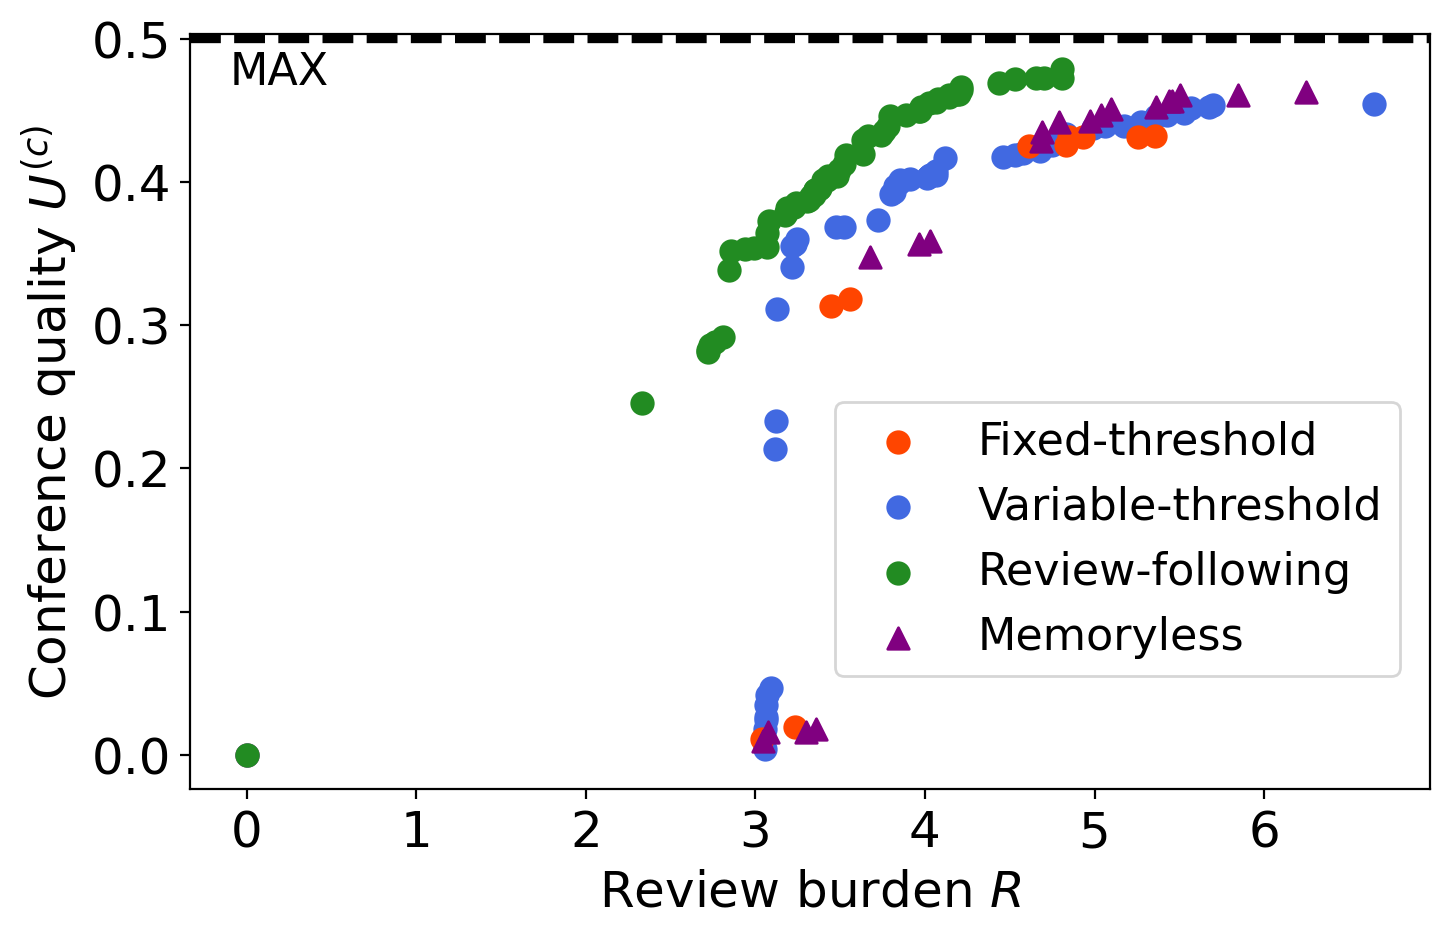

In [84]:
beta = 0.75
alpha = 0.75
eta = 0.5
T = 5
V = 5
m = 3
plt.figure(figsize=(8,5), dpi= 200)
Colors = ['orangered','royalblue','forestgreen']


Uc_2 = np.load("Results/Institutional_memory_binary/Variable_threshold_beta_"+str(beta)+"_alpha_"
                +str(alpha)+"_T_"+str(T)+"_V_"+str(V)+"_eta_"+str(eta)+"_m_"+str(m)+"_Uc.npy")
R_2 = np.load("Results/Institutional_memory_binary/Variable_threshold_beta_"+str(beta)+"_alpha_"
              +str(alpha)+"_T_"+str(T)+"_V_"+str(V)+"_eta_"+str(eta)+"_m_"+str(m)+"_R.npy")
Uc_po, R_po,index = Pareto_optimal(Uc_2,R_2)
P2 = plt.scatter(R_po,Uc_po,c=Colors[1],s= 60)

Uc_3 = np.load("Results/Institutional_memory_binary/Review_following_beta_"+str(beta)+"_alpha_"
                +str(alpha)+"_T_"+str(T)+"_V_"+str(V)+"_eta_"+str(eta)+"_m_"+str(m)+"_Uc.npy")
R_3 = np.load("Results/Institutional_memory_binary/Review_following_beta_"+str(beta)+"_alpha_"
              +str(alpha)+"_T_"+str(T)+"_V_"+str(V)+"_eta_"+str(eta)+"_m_"+str(m)+"_R.npy")
Uc_po, R_po,index = Pareto_optimal(Uc_3,R_3)
P3 = plt.scatter(R_po,Uc_po,c=Colors[2],s= 60)

Uc_po, R_po,index = Pareto_optimal(Uc_1,R_1)
P1 = plt.scatter(R_po,Uc_po,c=Colors[0],s= 60)

Uc_po, R_po,index = Pareto_optimal(Uc_4,R_4)
P4 = plt.scatter(R_po,Uc_po,marker='^',c='Purple',s= 60)

for i in range(3):
    plt.scatter(0,0,c=Colors[i],s= 60)
plt.legend([P1,P2,P3,P4], ['Fixed-threshold', 'Variable-threshold', 'Review-following','Memoryless'], fontsize = 16, loc=(0.52,0.15))
plt.tick_params(labelsize=18)
plt.xlabel(r'Review burden $R$', fontsize=18)
plt.ylabel(r'Conference quality $U^{(c)}$', fontsize=18)
plt.axhline(y=0.5, color='black', linestyle='--', linewidth = 3)
plt.text(-0.1,0.468,'MAX', fontsize=16, color='black')

